# Grad-CAM 

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import model_from_json

from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
import matplotlib

In [2]:
def load_model(file_json, file_h5):
    json_file = open(file_json, 'r')               
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights(file_h5)
    
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

    return model 

In [3]:
def Get_GradCam(json, h5, image_path, last_conv_layer_name, col1, task="PD", fig_name=False, return_heatmap=False):

    if task=="TD":
        tube_idx = {"Chest_drain_Ann": 0, "NSG_tube_Ann": 1, "Endotracheal_tube_Ann": 2, "Tracheostomy_tube_Ann": 3,
               "Chest_drain_tube_PadChest": 0, "NSG_tube_PadChest": 1, "Endotracheal_tube_PadChest": 2, "Tracheostomy_tube_PadChest": 3}
        pred_index = tube_idx[col1]
        title_idx = {v: k for k, v in tube_idx.items()}
    else:
        pathology_idx = {"Effusion": 0, "Pneumothorax": 1, "Atelectasis": 2, "Cardiomegaly": 3, "Pneumonia": 4}
        pred_index = pathology_idx[col1]
        title_idx = {v: k for k, v in pathology_idx.items()}

    img = keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = np.expand_dims(keras.preprocessing.image.img_to_array(img), 0)
    img_array /= 255

    model = load_model(json, h5) 
    model.layers[-1].activation = None

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    # For visualization purpose, we will also normalize the heatmap between 0 & 1 then 0 t0 255 for viz
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]
    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_size[1], img_size[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    if return_heatmap: 
        return jet_heatmap
    else: 
        jet_heatmap /= 255

    # Superimpose the heatmap on original image
    superimposed_image = keras.preprocessing.image.array_to_img(jet_heatmap * alpha + img_array[0])

    # create figure
    fig = plt.figure(figsize=(5, 3))
    plt.imshow(superimposed_image)
    plt.axis('off')
    if fig_name:
        plt.savefig(fig_name, bbox_inches="tight")
    else: 
        plt.title(title_idx[pred_index])
    plt.show()

In [4]:
# Using Anno to get the image paths
Anno = pd.read_csv('../Data/Data_splits/tube_detection-Annotations.csv', index_col=0)
Anno = Anno[["ImagePath"]]

preds = pd.read_csv("../Task-Tube_detection/Predictions/TD_preds_fine_dataframe.csv", index_col=0)
preds = Anno.merge(preds, how='inner', left_index=True, right_index=True)

# Tube detection 

In [5]:
# specify different parameters etc. 
last_conv_layer_name = "conv5_block16_2_conv"
di = '../Task-Tube_detection/'
h5 = di+"Saved_models/TD_multiclass_densenet_fine_sigmoid_250epochs_model2.h5"
json = di+"Saved_models/TD_multiclass_densenet_fine_sigmoid_250epochs_model2.json"
num_classes = 4
img_size = (512,512)
alpha = 0.4

## Most Certain 
### with a present tube annotation

In [6]:
def find_images(df, col1, col2, present):
    max_confidence = max(df[col2])
    print("max confidence for the tube type:", max_confidence)
    
    if present:
        temp = df[df[col1] == 1]
        temp = temp.sort_values(by=[col2], ascending=False)
    else: 
        temp = df.copy()
        temp = temp.sort_values(by=[col2], ascending=False)

    return temp 

max confidence for the tube type: 0.9138033


2023-05-30 12:03:04.993284: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-30 12:03:04.994497: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


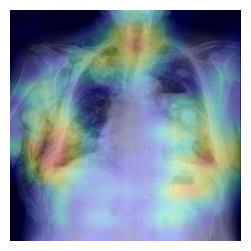

Model prediction: 0.8883956
Annotation: 1



In [7]:
col1 = "Chest_drain_Ann"
col2 = "preds_CheD_model2"
temp = find_images(preds, col1, col2, present=True)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1,  task="TD", fig_name="Grad_CAM_CheD_certain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.92801255


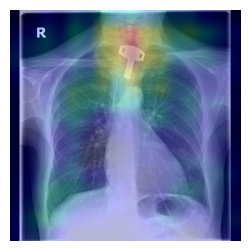

Model prediction: 0.92801255
Annotation: 1



In [8]:
col1 = "Tracheostomy_tube_Ann"
col2 = "preds_Trach_model2"
temp = find_images(preds, col1, col2, present=True)
num_images = 1


for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1,  task="TD", fig_name="Grad_CAM_Trach_certain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.92327094


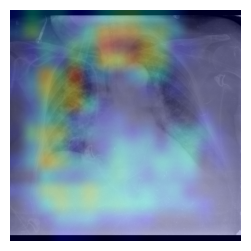

Model prediction: 0.92327094
Annotation: 1



In [9]:
col1 = "Endotracheal_tube_Ann"
col2 = "preds_Endo_model2"
temp = find_images(preds, col1, col2, present=True)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_Endo_certain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.9906979


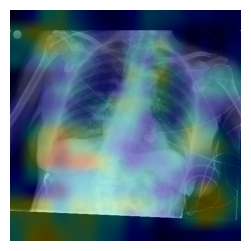

Model prediction: 0.9883255
Annotation: 1



In [10]:
col1 = "NSG_tube_Ann"
col2 = "preds_NSG_model2"
temp = find_images(preds, col1, col2, present=True)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_NSG_certain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

## Uncertain Images 
### All images

In [11]:
def find_uncertain(df, col1, col2):
    max_confidence = max(df[col2])
    print("max confidence for the tube type:", max_confidence)
    
    closest_uncertain = min(df[col2], key=lambda x:abs(x-0.5))
    print("least confident value", closest_uncertain)
    
    temp = df[df[col2] == closest_uncertain]

    return temp 

max confidence for the tube type: 0.9138033
least confident value 0.4946488


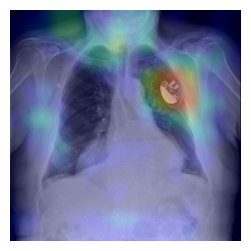

Model prediction: 0.4946488
Annotation: 0



In [12]:
col1 = "Chest_drain_Ann"
col2 = "preds_CheD_model2"
temp = find_uncertain(preds, col1, col2)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_CheD_uncertain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.92801255
least confident value 0.49987563


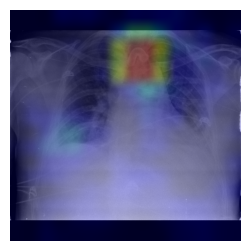

Model prediction: 0.49987563
Annotation: 1



In [13]:
col1 = "Tracheostomy_tube_Ann"
col2 = "preds_Trach_model2"
temp = find_uncertain(preds, col1, col2)
num_images = 1


for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_Trach_uncertain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.92327094
least confident value 0.5002793


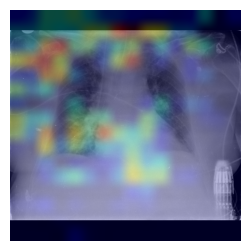

Model prediction: 0.5002793
Annotation: 1



In [14]:
col1 = "Endotracheal_tube_Ann"
col2 = "preds_Endo_model2"
temp = find_uncertain(preds, col1, col2)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_Endo_uncertain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.9906979
least confident value 0.5005698


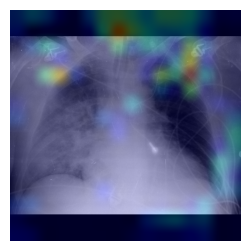

Model prediction: 0.5005698
Annotation: 0



In [15]:
col1 = "NSG_tube_Ann"
col2 = "preds_NSG_model2"
temp = find_uncertain(preds, col1, col2)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_NSG_uncertain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

## Cherry pick Grad-CAM images 
### With a present tube annotations

max confidence for the tube type: 0.92801255
4


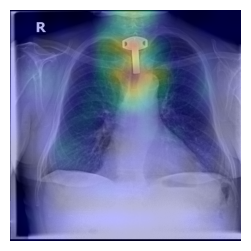

Model prediction: 0.83359927
Annotation: 1



In [16]:
col1 = "Tracheostomy_tube_Ann"
col2 = "preds_Trach_model2"
temp = find_images(preds, col1, col2, present=True)
num_images = 5

for i in range(4, num_images):
    print(i)
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_Trach_cherry.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.9906979
0


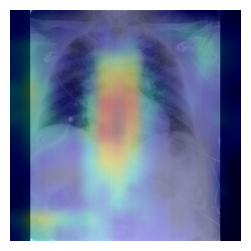

Model prediction: 0.9906979
Annotation: 1



In [17]:
col1 = "NSG_tube_PadChest"
col2 = "preds_NSG_model2"
temp = find_images(preds, col1, col2, present=True)
num_images = 1

for i in range(0, num_images):
    print(i)
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_NSG_cherry.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.92327094
3


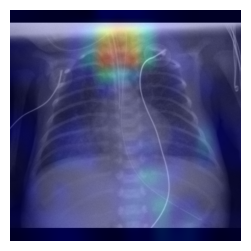

Model prediction: 0.8305419
Annotation: 1



In [18]:
col1 = "Endotracheal_tube_Ann"
col2 = "preds_Endo_model2"
temp = find_images(preds, col1, col2, present=True)
num_images = 4

for i in range(3, num_images):
    print(i)
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_Endo_cherry.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.9138033
15


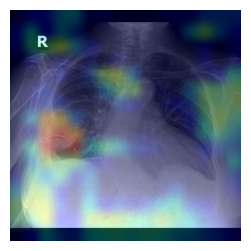

Model prediction: 0.30111346
Annotation: 1



In [19]:
col1 = "Chest_drain_Ann"
col2 = "preds_CheD_model2"
temp = find_images(preds, col1, col2, present=True)
num_images = 16

for i in range(15, num_images):
    print(i)
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="TD", fig_name="Grad_CAM_CheD_cherry.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

# Pathology Grad-CAM

In [20]:
last_conv_layer_name = "conv5_block16_2_conv"
di = '../Task-Pathology_detection/'
h5 = di+"Saved_models/PD_9layers_30epochs_model1.h5"
json = di+"Saved_models/PD_9layers_30epochs_model1.json"
num_classes = 4
img_size = (512,512)
alpha = 0.4

## Finding the images 

In [21]:
preds1 = pd.read_csv("../Task-Pathology_detection/Predictions/PD_preds_fine_dataframe.csv", index_col=0)

In [22]:
# Function to change the image paths. From purrlab_students to a Data folder with the preprocessed images  
def change_paths(df):
    df = df.copy()
    df["ImagePath"] = ["../../Data/" + df["ImagePath"][idx][26:] for idx in range(len(df))]
    return df

preds = change_paths(preds1)
preds.ImagePath[0]

'../../Data/padchest-preprocessed/5/122000277774965864047324735331704213150_58hj8t.png'

max confidence for the tube type: 0.770255506


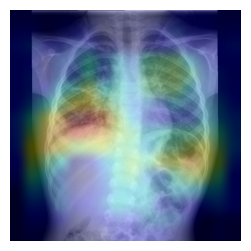

Model prediction: 0.756930351
Annotation: 1



In [23]:
col1 = "Pneumonia"
col2 = "preds_Pneumonia_model1"
temp = find_images(preds, col1, col2, present=True)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, task="PD", fig_name="Grad_CAM_Pneumonia_certain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.966457188


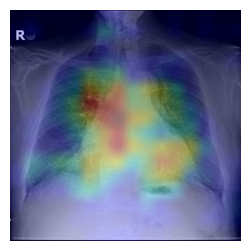

Model prediction: 0.966457188
Annotation: 1



In [24]:
col1 = "Cardiomegaly"
col2 = "preds_Cardiomegaly_model1"
temp = find_images(preds, col1, col2, present=True)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, fig_name="Grad_CAM_Cardiomegaly_certain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.48820585


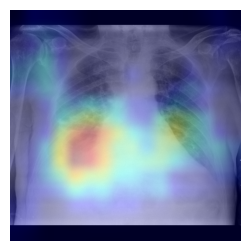

Model prediction: 0.397485703
Annotation: 1



In [25]:
col1 = "Atelectasis"
col2 = "preds_Atelectasis_model1"
temp = find_images(preds, col1, col2, present=True)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, fig_name="Grad_CAM_Atelectasis_certain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.999482214


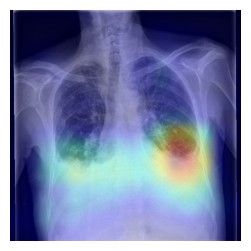

Model prediction: 0.999482214
Annotation: 1



In [26]:
col1 = "Effusion"
col2 = "preds_Effusion_model1"
temp = find_images(preds, col1, col2, present=True)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, fig_name="Grad_CAM_Effusion_certain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.0401938446


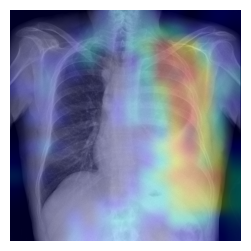

Model prediction: 0.0204861481
Annotation: 1



In [27]:
col1 = "Pneumothorax"
col2 = "preds_Pneumothorax_model1"
temp = find_images(preds, col1, col2, present=True)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, fig_name="Grad_CAM_Pneumothorax_certain.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

## Uncertain 
### pathology present

In [28]:
def find_uncertain(df, col1, col2):
    max_confidence = max(df[col2])
    print("max confidence for the tube type:", max_confidence)
    
    temp = df[df[col1] == 1]
    
    closest_uncertain = min(temp[col2], key=lambda x:abs(x-0.5))
    print("least confident value", closest_uncertain)
    
    temp = temp[temp[col2] == closest_uncertain]

    return temp 

max confidence for the tube type: 0.0401938446
least confident value 0.0204861481


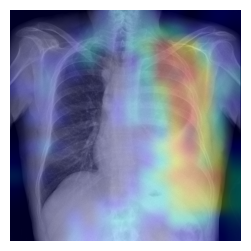

Model prediction: 0.0204861481
Annotation: 1



In [29]:
col1 = "Pneumothorax"
col2 = "preds_Pneumothorax_model1"
temp = find_uncertain(preds, col1, col2)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, fig_name="Grad_CAM_Pneumothorax_uncertain_present.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.770255506
least confident value 0.508330703


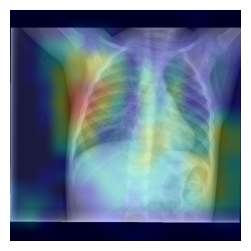

Model prediction: 0.508330703
Annotation: 1



In [30]:
col1 = "Pneumonia"
col2 = "preds_Pneumonia_model1"
temp = find_uncertain(preds, col1, col2)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, fig_name="Grad_CAM_Pneumonia_uncertain_present.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.966457188
least confident value 0.500676274


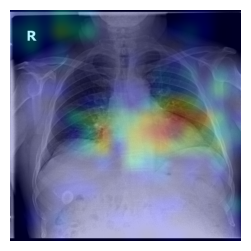

Model prediction: 0.500676274
Annotation: 1



In [31]:
col1 = "Cardiomegaly"
col2 = "preds_Cardiomegaly_model1"
temp = find_uncertain(preds, col1, col2)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, fig_name="Grad_CAM_Cardiomegaly_uncertain_present.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print()

max confidence for the tube type: 0.48820585
least confident value 0.397485703


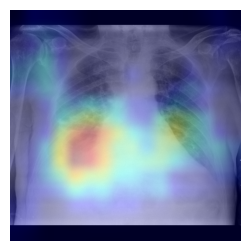

Model prediction: 0.397485703
Annotation: 1
Atelectasis : 1



In [32]:
col1 = "Atelectasis"
col2 = "preds_Atelectasis_model1"
temp = find_uncertain(preds, col1, col2)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, fig_name="Grad_CAM_Atelectasis_uncertain_present.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print(col1, ":", temp[col1].tolist()[i])

    print()

max confidence for the tube type: 0.999482214
least confident value 0.500297964


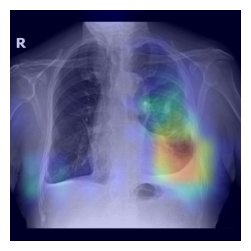

Model prediction: 0.500297964
Annotation: 1
Effusion : 1



In [33]:
col1 = "Effusion"
col2 = "preds_Effusion_model1"
temp = find_uncertain(preds, col1, col2)
num_images = 1

for i in range(num_images):
    Get_GradCam(json, h5, temp["ImagePath"].tolist()[i], last_conv_layer_name, col1, fig_name="Grad_CAM_Effusion_uncertain_present.png")
    print("Model prediction:", temp[col2].tolist()[i])
    print("Annotation:", temp[col1].tolist()[i])
    print(col1, ":", temp[col1].tolist()[i])

    print()